In [1]:
# https://www.cs.toronto.edu/~kriz/cifar.html
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [3]:
files = unpickle('./data/data_batch_1')
files.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [4]:
data = files[b'data']
labels = files[b'labels']

In [5]:
data.shape

(10000, 3072)

In [6]:
data = data.reshape(10000, 3, 32, 32)
data.shape

(10000, 3, 32, 32)

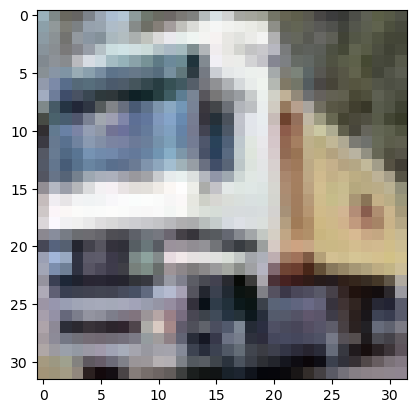

In [7]:
imshow(data[1])

In [8]:
labels[1]

9

In [9]:
classes[labels[1]]

'truck'

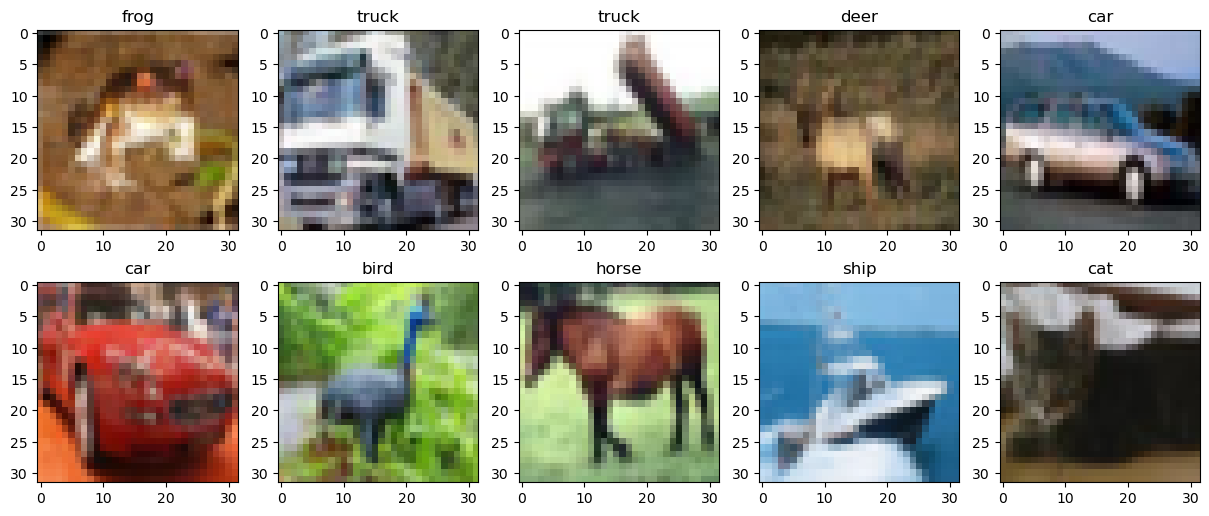

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
idx=0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(data[idx].transpose(1, 2, 0))
        ax[i, j].set_title(classes[labels[idx]])
        idx += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x.shape: torch.Size([3, 32, 32])
y: tensor(6)


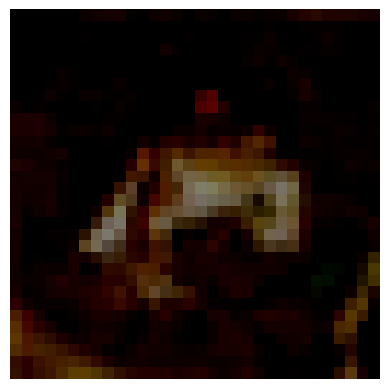

In [11]:
import torch

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x=x  
        self.y=y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x=self.x[idx]
        y=self.y[idx]
        y=torch.tensor(y)
        x=torch.tensor(x, dtype=torch.float32)
        x=x/255.0-0.5
        return x, y
    
dataset_sample=MyDataset(data, labels)
x, y=dataset_sample[0]
print("x.shape:", x.shape)          # torch.Size([784])
print("y:", y)                      # tensor(5)

plt.imshow(x.permute(1, 2, 0))
plt.axis('off')
plt.show()



In [12]:
x

tensor([[[-0.2686, -0.3314, -0.3039,  ...,  0.1196,  0.0961,  0.0804],
         [-0.4373, -0.5000, -0.4294,  ..., -0.0176, -0.0333, -0.0216],
         [-0.4020, -0.4373, -0.3078,  ..., -0.0373, -0.0294, -0.0725],
         ...,
         [ 0.3157,  0.2882,  0.2765,  ...,  0.1275, -0.2804, -0.2922],
         [ 0.2059,  0.1784,  0.2294,  ...,  0.2216, -0.1196, -0.1745],
         [ 0.1941,  0.1588,  0.2020,  ...,  0.3471,  0.0922, -0.0176]],

        [[-0.2569, -0.3196, -0.3118,  ...,  0.0176, -0.0098, -0.0137],
         [-0.4216, -0.5000, -0.4686,  ..., -0.1549, -0.1745, -0.1588],
         [-0.4059, -0.4725, -0.3941,  ..., -0.1706, -0.1706, -0.2137],
         ...,
         [ 0.1667,  0.1000,  0.1314,  ...,  0.0216, -0.3784, -0.3667],
         [ 0.0451, -0.0176,  0.0647,  ...,  0.0804, -0.2569, -0.2922],
         [ 0.0647,  0.0059,  0.0569,  ...,  0.2216, -0.0373, -0.1392]],

        [[-0.2529, -0.3235, -0.3314,  ..., -0.0765, -0.1000, -0.0961],
         [-0.4216, -0.5000, -0.5000,  ..., -0

In [13]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.adjust_channels_conv_1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm_2d=torch.nn.BatchNorm2d(out_channels)
        self.relu=torch.nn.ReLU()
        
    def forward(self, input):
        x=input[0]
        identity=input[1]
        x=self.conv1(x)
        x=self.batch_norm_2d(x)
        x=self.relu(x)
        identity=self.adjust_channels_conv_1(identity)
        x=torch.add(x, identity)
        return x, identity
    
class ConvBlockMaxPool(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.adjust_channels_conv_1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm_2d=torch.nn.BatchNorm2d(out_channels)
        self.relu=torch.nn.ReLU()
        self.maxpool=torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
    def forward(self, input):
        x=input[0]
        identity=input[1]
        x=self.conv1(x)
        x=self.batch_norm_2d(x)
        x=self.relu(x)
        identity=self.adjust_channels_conv_1(identity)
        x=torch.add(x, identity)
        x=self.maxpool(x)
        identity=self.maxpool(identity)
        return x, identity
    
class DebugLayer(torch.nn.Module):
    def __init__(self, text):
        super().__init__()
        self.text=text
        
    def forward(self, input):
        x=input[0]
        identity=input[1]
        print(self.text, "x.shape:", x.shape)
        return x, identity


class CifarModel(torch.nn.Module):
    def __init__(self, hidden_size=None, dropout=0.4):
        super().__init__()
        self.conv_layer=torch.nn.Sequential(
            ConvBlock(3, 64,),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            ConvBlockMaxPool(64, 128),          # 16x16
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            ConvBlockMaxPool(128, 256),         # 8x8
            ConvBlock(256, 256),
            ConvBlock(256, 256),
            ConvBlockMaxPool(256, 512),         # 4x4
            ConvBlock(512, 512),
            ConvBlock(512, 512),
            ConvBlockMaxPool(512, 1024),         # 2x2
            #DebugLayer("afer 512, 1024 maxpool"),
            ConvBlock(1024, 1024),
            ConvBlock(1024, 1024)
        )
     
        self.conv_size=1024*2*2
        self.lin1=torch.nn.Linear(self.conv_size, hidden_size)
        self.batch_norm_lin1=torch.nn.BatchNorm1d(hidden_size)
        self.lin2=torch.nn.Linear(hidden_size, 10)
        self.relu=torch.nn.ReLU()                           
        self.softmax=torch.nn.Softmax(dim=1)                
        self.dropout=torch.nn.Dropout(p=dropout)   
 
    def forward(self, x):
        x=x.view(-1, 3, 32, 32)
        #print("x.shape nach x.view:", x.shape)
        original_x=x.clone()
        x, identity=self.conv_layer((x, original_x))
        
        #print("x.shape nach conv:", x.shape)
        # flatten
        x=x.view(-1, self.conv_size)
        #print("x.shape nach x.view:", x.shape)
        x=self.lin1(x)
        x=self.batch_norm_lin1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.lin2(x)
        x=self.softmax(x)
        #print("x.shape nach lin1:", x.shape)
        return x
    
# wir bauen das Modell
model=CifarModel(hidden_size=100)
# wir bauen das Dataset
dataset_sample=MyDataset(data, labels)
# wir bauen den DataLoader
loader=torch.utils.data.DataLoader(dataset_sample, batch_size=13, shuffle=True)
# ein einziges Batch-Beispiel wird aus dem Dataloader geladen
for xb, yb in loader:
    print(model(xb).shape)
    assert model(xb).shape==torch.Size([13, 10]), "Error: model(xb).shape!=torch.Size([13, 10])"
    break


torch.Size([13, 10])


In [14]:
from sklearn.model_selection import train_test_split

# wir bauen das Dataset
# stratify=mnist_trainset.targets sorgt dafür, dass die Klassenverteilung im Trainings- und Validierungsset gleich ist
x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2, stratify=labels)
train_dataset=MyDataset(x_train, y_train)
valid_dataset=MyDataset(x_valid, y_valid)


In [15]:
lr=0.0001
batch_size=64
epochs=40
hidden_size=150

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

#device=torch.device('cpu')

model=CifarModel(hidden_size).to(device)
#weight_decay: Hohe Gewichte werden bestraft, um Overfitting zu vermeiden
optimizer=torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)
# CrossEntropyLoss: Klassifikationsproblem mit mehreren Klassen
loss_func=torch.nn.CrossEntropyLoss()

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

losses=[]
valid_losses=[]

bar=tqdm(range(epochs))
for i in bar:
    model.train()
    epoch_losses=[]
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()                   # Gradienten (Ableitungen) zurücksetzen
        pred=model(xb)                          # Forward-Propagation
        loss=loss_func(pred, yb)                # Loss berechnen
        loss.backward()                         # ableiten
        optimizer.step()                        # Gewichte aktualisieren
        epoch_losses.append(loss.item())        # Loss speichern
    losses.append(sum(epoch_losses)/len(epoch_losses))
    valid_losses_epoch=[]
    with torch.no_grad():                       # Alles was hier kommt, wird nicht für die Berechnung der Gradienten verwendet
        correct = 0
        model.eval()
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred=model(xb)
            loss=loss_func(pred, yb)
            valid_losses_epoch.append(loss.item())
            correct += (torch.argmax(pred, dim=1) == yb).sum().item()
    valid_losses.append(sum(valid_losses_epoch)/len(valid_losses_epoch))
    bar.set_postfix({'train_loss': losses[-1], 'valid_loss': valid_losses[-1], 'accuracy': correct/len(valid_dataset)})

plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.show()
correct = 0
total = 0

with torch.no_grad():
    model.eval()
    # Schleife über alle Validierungsdaten
    for xb, yb in valid_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)                            # Vorhersage holen
        _, predicted = torch.max(pred.data, 1)      # Index des größten Wertes holen
        total += yb.size(0)                         # Anzahl der Validierungdaten
        correct += (predicted == yb).sum().item()   # predicted und yb vergleichen und Anzahl der richtigen Vorhersagen zählen

accuracy = correct / total
print("Accuracy:", accuracy)

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
bar=tqdm(range(epochs))
for i in bar:
    model.train()
    epoch_losses=[]
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()                   # Gradienten (Ableitungen) zurücksetzen
        pred=model(xb)                          # Forward-Propagation
        loss=loss_func(pred, yb)                # Loss berechnen
        loss.backward()                         # ableiten
        optimizer.step()                        # Gewichte aktualisieren
        epoch_losses.append(loss.item())        # Loss speichern
    losses.append(sum(epoch_losses)/len(epoch_losses))
    valid_losses_epoch=[]
    with torch.no_grad():                       # Alles was hier kommt, wird nicht für die Berechnung der Gradienten verwendet
        correct = 0
        model.eval()
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred=model(xb)
            loss=loss_func(pred, yb)
            valid_losses_epoch.append(loss.item())
            correct += (torch.argmax(pred, dim=1) == yb).sum().item()
    valid_losses.append(sum(valid_losses_epoch)/len(valid_losses_epoch))
    bar.set_postfix({'train_loss': losses[-1], 'valid_loss': valid_losses[-1], 'accuracy': correct/len(valid_dataset)})
    
    


  0%|          | 0/40 [00:00<?, ?it/s]

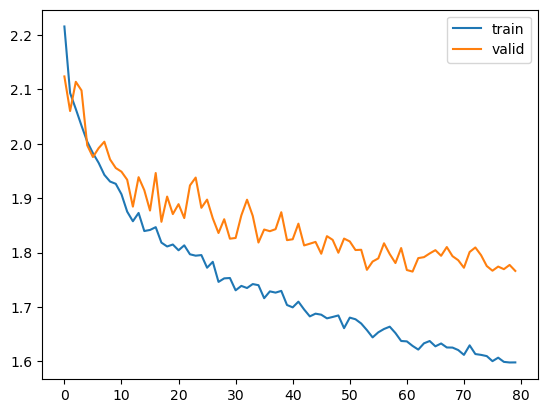

Accuracy: 0.691


In [ ]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.show()
correct = 0
total = 0

with torch.no_grad():
    model.eval()
    # Schleife über alle Validierungsdaten
    for xb, yb in valid_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)                            # Vorhersage holen
        _, predicted = torch.max(pred.data, 1)      # Index des größten Wertes holen
        total += yb.size(0)                         # Anzahl der Validierungdaten
        correct += (predicted == yb).sum().item()   # predicted und yb vergleichen und Anzahl der richtigen Vorhersagen zählen

accuracy = correct / total
print("Accuracy:", accuracy)